In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision 
import os
import torch
from torch import nn as nn
import numpy as np
import glob
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from torchmetrics.classification import BinaryAccuracy, Accuracy, MulticlassAccuracy, MultilabelAccuracy
import matplotlib.pyplot as plt
from math import copysign
import seaborn as sn

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


CREATE DATASET CLASS

In [115]:
class WasteDataSet(Dataset):
    def __init__(self, path: str="./data/train/", transform=None, labels_dict=None):
        self.path = path
        self.transform = transform
        self.labels_dict = labels_dict
        self.images_path = glob.glob(self.path + "**/*.jpg", recursive=True)
    
    def __len__(self):
        length = 0
        for k in self.labels_dict:
            labelpath = self.path+k
            length += len(os.listdir(labelpath))
        return length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images_path[idx]
        # image = Image.open(img_path)
        image = torchvision.io.read_image(img_path).float()
        label_name = img_path.split("/")[-2]
        label = torch.tensor(self.labels_dict[label_name]).float()
        if self.transform:
            image = self.transform(image)
        
        return image, label 

CREATE MODEL CLASS

In [116]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load pretrained ResNet50
        self.resnet = torchvision.models.resnet50(weights="DEFAULT")
        self.head_in_features = self.resnet.fc.in_features
        # Skip last layer
        self.resnet.fc = nn.Identity()
        # Add 3 heads
        self.head1 = nn.Linear(self.head_in_features, 2)
        self.head2 = nn.Linear(self.head_in_features, 4)
        self.head3 = nn.Linear(self.head_in_features, 4)
        
        # Freeze first 6 sequential layers
        counter = 0
        for child in self.resnet.children():
            if counter < 6:
                for param in child.parameters():
                    param.requires_grad = False
            counter += 1

    def forward(self, x):
        features = self.resnet(x)
        y1 = torch.softmax(self.head1(features), dim=1)
        y2 = torch.sigmoid(self.head2(features))
        y3 = torch.sigmoid(self.head3(features))
        return torch.hstack((y1, y2, y3))

MAKE ARRANGEMENTS

In [117]:
# Assign parameters
train_path = "./data/train/"
test_path = "./data/test/"

# Create transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# torchvision.transforms.ToTensor()
#    torchvision.transforms.RandomResizedCrop(size=(224,224)),
    #torchvision.transforms.RandomHorizontalFlip(),

# Create multilabel dictionary
labels_dict = { "biodegradable":    [1,0,1,1,1,1,0,0,0,0],
                "b_food":           [1,0,1,0,0,0,0,0,0,0],
                "b_leaf":           [1,0,0,1,0,0,0,0,0,0],
                "b_paper":          [1,0,0,0,1,0,0,0,0,0],
                "b_wood":           [1,0,0,0,0,1,0,0,0,0],
                "nonbiodegradable": [0,1,0,0,0,0,1,1,1,1],
                "n_ewaste":         [0,1,0,0,0,0,1,0,0,0],
                "n_metal":          [0,1,0,0,0,0,0,1,0,0],
                "n_bags":           [0,1,0,0,0,0,0,0,1,0],
                "n_bottles":        [0,1,0,0,0,0,0,0,0,1]}

# Assign batch size
batch_size = 128
num_workers = 8

# Generate datasets
train_dataset = WasteDataSet(path=train_path, transform=train_transforms, labels_dict=labels_dict)
train_size = int(len(train_dataset) * 0.8)      # 80% training data
val_size = len(train_dataset) - train_size    # 20% validation data
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
test_data = WasteDataSet(path=test_path, transform=test_transforms, labels_dict=labels_dict)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Create model
model = ResNetModel()
model = model.to(device=device)
print(next(model.parameters()).device)


Train size: 248170, Validation size: 62043, Test size: 36198
cuda:0


PREDICT LABELS

In [129]:
def predictLabels(scores):
    # Split heads
    head1_predicts = scores[:,:2]
    head2_predicts = scores[:,2:6]
    head3_predicts = scores[:,6:10]    

    # Head 1
    head1_predicts[head1_predicts >= 0.5] = 1
    head1_predicts[head1_predicts < 0.5] = 0
    # Head 2
    subclass1_rows = np.where((head1_predicts == (1,0)).all(axis=1))
    head2_predicts[subclass1_rows, np.argmax(head2_predicts[subclass1_rows], axis=1)] = 1
    head2_predicts[head2_predicts < 1] = 0
    # Head 3
    subclass2_rows = np.where((head1_predicts == (0,1)).all(axis=1))
    head3_predicts[subclass2_rows, np.argmax(head3_predicts[subclass2_rows], axis=1)] = 1
    head3_predicts[head3_predicts < 1] = 0
    
    return np.hstack((head1_predicts, head2_predicts, head3_predicts))

EVALUATION METRICS

In [118]:
def getTrueIndices(targets):
    head2_targets = targets[:,2:6]
    head3_targets = targets[:,6:10]
    zs = np.array([[0,0,0,0]])
    ones = np.array([[1,1,1,1]])

    x = np.invert((head2_targets[:, None] == zs).all(-1))
    y = np.invert((head2_targets[:, None] == ones).all(-1))
    xy1 = list(np.logical_and(x, y).any(-1).nonzero()[0])

    x2 = np.invert((head3_targets[:, None] == zs).all(-1))
    y2 = np.invert((head3_targets[:, None] == ones).all(-1))
    xy2 = list(np.logical_and(x2, y2).any(-1).nonzero()[0])
    # print(xy1)
    # print(xy2)
    return xy1, xy2

In [119]:
def evaluate(predicts, targets, train=True):
    # Split heads
    head1_predicts = predicts[:,:2]
    head2_predicts = predicts[:,2:6]
    head3_predicts = predicts[:,6:10]
    head1_targets = targets[:,:2]
    head2_targets = targets[:,2:6]
    head3_targets = targets[:,6:10]

    Head1 = {}
    Head2 = {}
    Head3 = {}

    # Calculate main class accuracy
    metricMain = MulticlassAccuracy(num_classes=2, average='micro')
    labels_pred = np.argmax(head1_predicts, axis=1)
    labels_target = np.argmax(head1_targets, axis=1)  
    Head1["Accuracy"] = metricMain(torch.from_numpy(head1_predicts), torch.from_numpy(head1_targets)).item()
    Head1["ConfusionMatrix"] = confusion_matrix(labels_target, labels_pred, labels=[0, 1])

    metric = MulticlassAccuracy(num_classes=2, average=None)
    metricSub = MulticlassAccuracy(num_classes=4, average='micro')
    # Subclass 1, subclass 2
    xy1, xy2 = getTrueIndices(targets)
    if len(xy1) != 0:
        labels_pred = np.argmax(head2_predicts[xy1], axis=1)
        labels_target = np.argmax(head2_targets[xy1], axis=1)
        probs = metric(torch.from_numpy(head1_predicts[xy1]), torch.from_numpy(head1_targets[xy1]))
        Head2["Accuracy"] = metricSub(torch.from_numpy(labels_pred), torch.from_numpy(labels_target)).item()*probs[0].item()
        Head2["ConfusionMatrix"] = confusion_matrix(labels_target, labels_pred, labels=[0, 1, 2, 3])
    else:
        Head2["Accuracy"] = 0.0
        Head2["ConfusionMatrix"] = None
    if len(xy2) != 0:
        labels_pred = np.argmax(head3_predicts[xy2], axis=1)
        labels_target = np.argmax(head3_targets[xy2], axis=1)
        probs = metric(torch.from_numpy(head1_predicts[xy2]), torch.from_numpy(head1_targets[xy2]))
        Head3["Accuracy"] = metricSub(torch.from_numpy(labels_pred), torch.from_numpy(labels_target)).item()*probs[1].item()
        Head3["ConfusionMatrix"] = confusion_matrix(labels_target, labels_pred, labels=[0, 1, 2, 3])
    else:
        Head3["Accuracy"] = 0.0
        Head3["ConfusionMatrix"] = None        


    if train:
        return Head1["Accuracy"], Head2["Accuracy"], Head3["Accuracy"]
    else:
        return Head1, Head2, Head3

In [122]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [136]:
def round_up(x, digits):
    if x > 0:
        return round(x, digits)
    return -round(-x, digits)

TRAIN THE MODEL

In [14]:
# Hyper-parameters 
num_epochs = 10
learning_rate = 1e-5
# Losses and accuracies
train_losses = []
train_accs = [[],[],[]]
val_accss = [[],[],[]]

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# Use cross entropy loss classification for main classes and binary cross entropy for subclasses 
criterion1 = nn.CrossEntropyLoss()
# criterion2 = nn.CrossEntropyLoss(size_average=True, ignore_index=-1)
criterion2 = nn.BCELoss()
# criterion3 = nn.BCELoss()

# Iterate over all the dataset
for epoch in range(num_epochs):
    batch_losses = []
    batch_train_acc = [[],[],[]]
    batch_val_acc = [[],[],[]]
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            tepoch.set_description(f"Epoch Train {epoch}")
            # for i, (images, targets) in enumerate(train_loader):
            # print("before load")
            images = images.to(device)
            targets = targets.to(device)  
            # print("after load")

            # Zero grads before calculation
            optimizer.zero_grad()
            # Predict labels
            outputs = model(images)
            # Calculate loss
            # loss1 = criterion1(outputs[:,:2], targets[:,:2])
            # xy1, xy2 = getTrueIndices(targets.cpu().detach().numpy())
            # if len(xy1) != 0:
            #     loss2 = criterion2(outputs[xy1,2:6], targets[xy1,2:6])
            # else:
            #     loss2 = 0
            # if len(xy2) != 0:
            #     loss3 = criterion3(outputs[xy2,6:10], targets[xy2,6:10])
            # else:
            #     loss3 = 0
            loss1 = criterion1(outputs[:,:2], targets[:,:2])
            loss2 = criterion2(outputs[:,2:10], targets[:,2:10])

            # Calculate gradients
            # loss = loss1 + loss2 + loss3
            loss = loss1 + loss2
            loss.backward()
            batch_losses.append(loss.item())
            labels = predictLabels(outputs.cpu().detach().numpy())
            h1_acc, h2_acc, h3_acc = evaluate(labels, targets.cpu().detach().numpy())
            batch_train_acc[0].append(h1_acc)
            batch_train_acc[1].append(h2_acc)
            batch_train_acc[2].append(h3_acc)
            # Update weights
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), accuracy=(round_up(100.*h1_acc, 2), round_up(100. * h2_acc, 2), round_up(100. * h3_acc, 2)))
            
    train_losses.append(batch_losses)
    train_accs[0].append(batch_train_acc[0])
    train_accs[1].append(batch_train_acc[1])
    train_accs[2].append(batch_train_acc[2])

    # Do validation
    model.eval()
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as tepoch:
            for images, targets in tepoch:
                tepoch.set_description(f"Epoch Val {epoch}")
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                labels = predictLabels(outputs.cpu().detach().numpy())
                h1_acc, h2_acc, h3_acc = evaluate(labels, targets.cpu().detach().numpy())
                batch_val_acc[0].append(h1_acc)
                batch_val_acc[1].append(h2_acc)
                batch_val_acc[2].append(h3_acc)
                tepoch.set_postfix(loss=-1, accuracy=(round_up(100. * h1_acc, 2), round_up(100. * h2_acc, 2), round_up(100. * h3_acc, 2)))

        val_accss[0].append(batch_val_acc[0])
        val_accss[1].append(batch_val_acc[1])
        val_accss[2].append(batch_val_acc[2])
        
    model.train()
    scheduler.step()
    save_checkpoint(model, optimizer, "E"+str(epoch)+".pt", epoch)

with open('train_accs.pkl', 'wb') as f:
    pickle.dump(train_accs, f)
with open('val_accss.pkl', 'wb') as f:
    pickle.dump(val_accss, f)

Epoch Val 9: 100%|██████████| 485/485 [02:08<00:00,  3.76batch/s, accuracy=(100.0, 100.0, 100.0), loss=-1]


In [15]:
print(np.array(train_losses).flatten().shape)

(19390,)


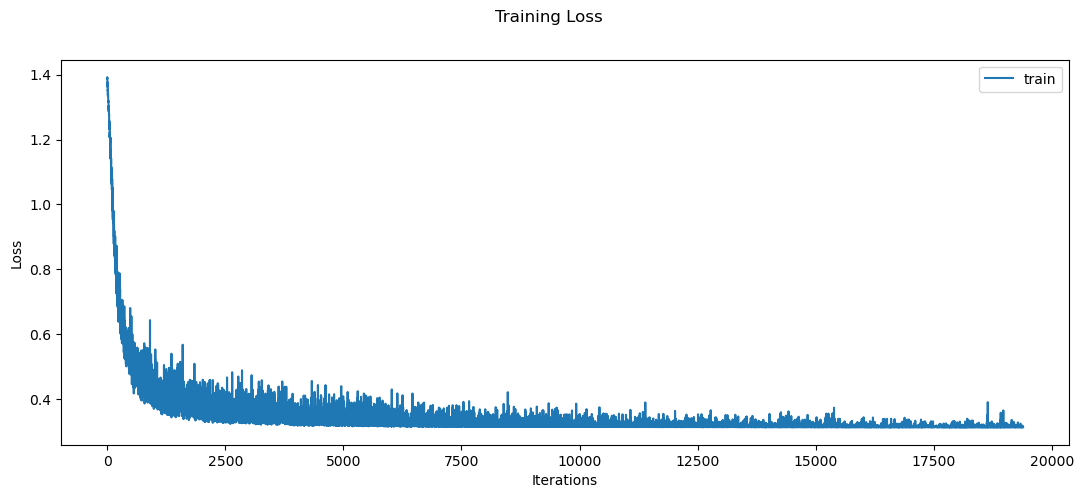

In [21]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Training Loss")
ax1.plot(np.array(train_losses).flatten(),label="train")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(np.array(train_accs[0]).shape)

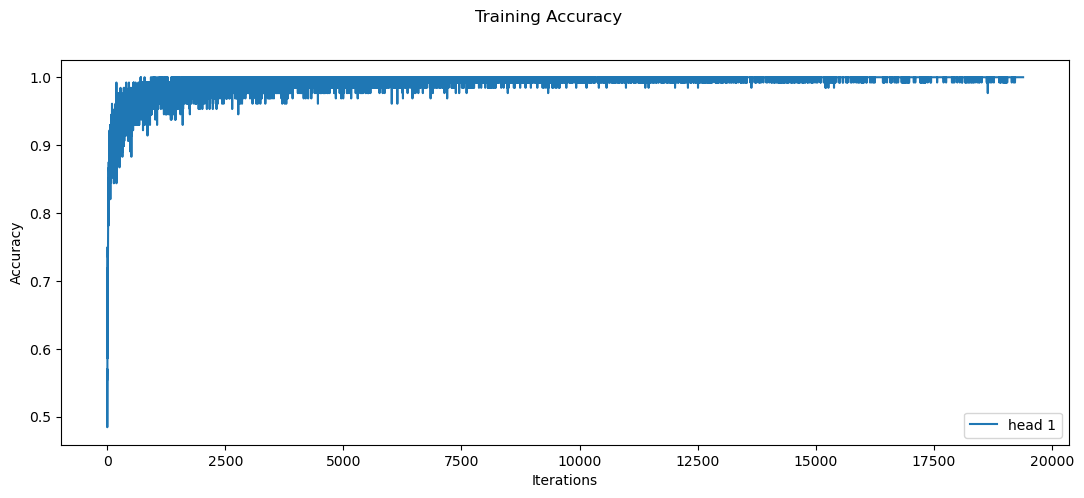

In [24]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Training Accuracy")
ax1.plot(np.array(train_accs[0]).flatten(),label="head 1")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

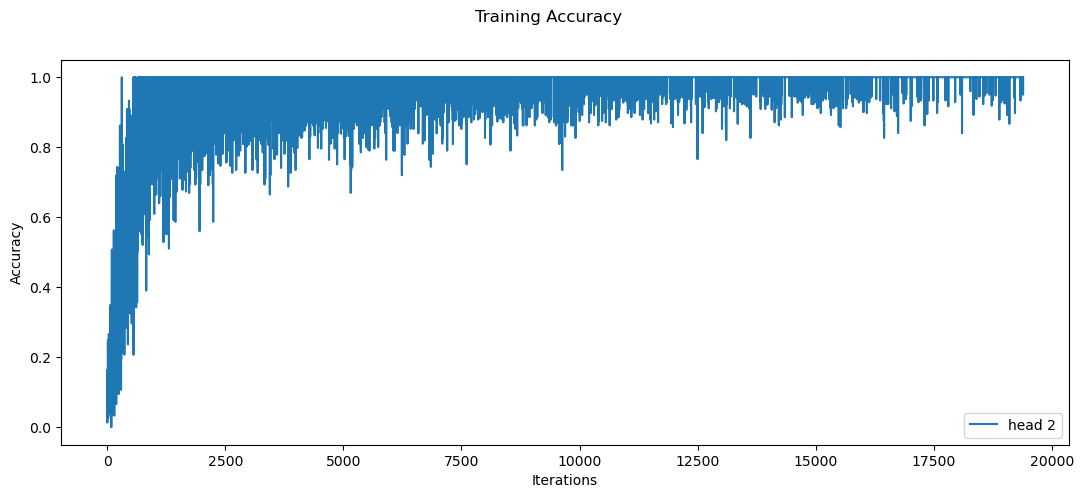

In [25]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Training Accuracy")
ax1.plot(np.array(train_accs[1]).flatten(),label="head 2")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

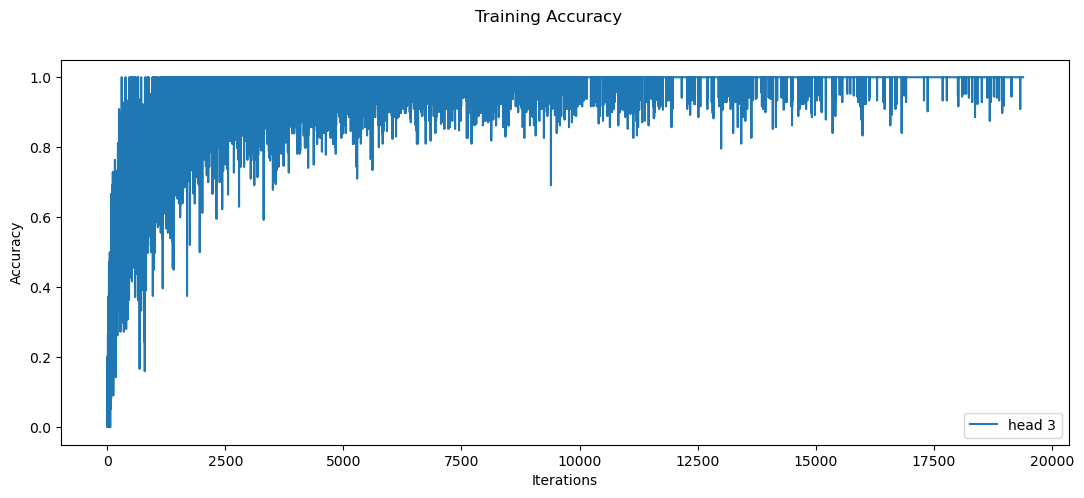

In [27]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Training Accuracy")
ax1.plot(np.array(train_accs[2]).flatten(),label="head 3")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

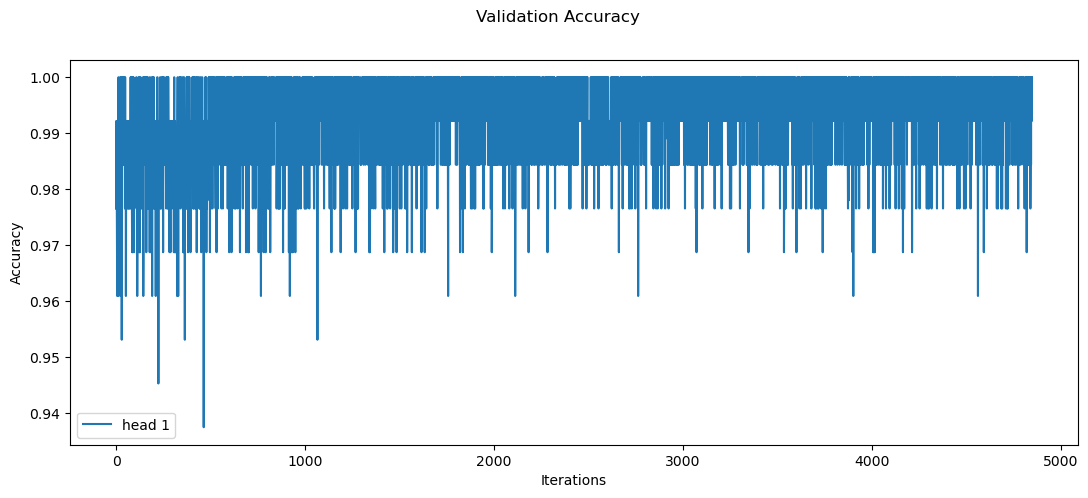

In [28]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Validation Accuracy")
ax1.plot(np.array(val_accss[0]).flatten(),label="head 1")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

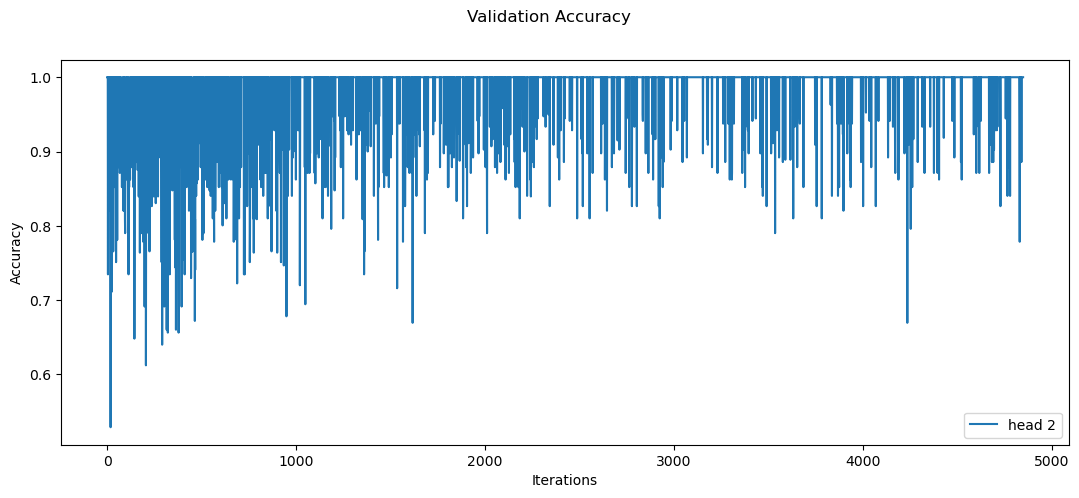

In [29]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Validation Accuracy")
ax1.plot(np.array(val_accss[1]).flatten(),label="head 2")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

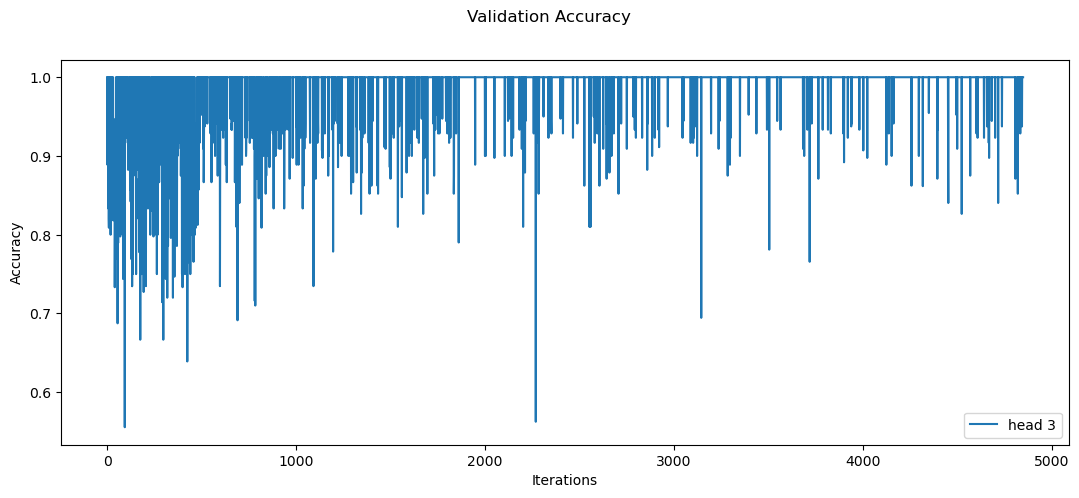

In [30]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Validation Accuracy")
ax1.plot(np.array(val_accss[2]).flatten(),label="head 3")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
batch_test_acc = [[],[],[]]
test_accss = [[],[],[]]
confusion1 = np.zeros((2,2))
confusion2 = np.zeros((4,4))
confusion3 = np.zeros((4,4))
model.eval()
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            tepoch.set_description("Test data")
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            labels = predictLabels(outputs.cpu().detach().numpy())
            h1_acc, h2_acc, h3_acc = evaluate(labels, targets.cpu().detach().numpy(), train=False)
            batch_test_acc[0].append(h1_acc["Accuracy"])
            batch_test_acc[1].append(h2_acc["Accuracy"])
            batch_test_acc[2].append(h3_acc["Accuracy"])
            if h1_acc["ConfusionMatrix"] is not None:
                confusion1 += h1_acc["ConfusionMatrix"]
            if h2_acc["ConfusionMatrix"] is not None:
                confusion2 += h2_acc["ConfusionMatrix"] 
            if h3_acc["ConfusionMatrix"] is not None:
                confusion3 += h3_acc["ConfusionMatrix"]                                
            tepoch.set_postfix(loss=-1, accuracy=(round_up(100. * h1_acc["Accuracy"], 2), round_up(100. * h2_acc["Accuracy"], 2), round_up(100. * h3_acc["Accuracy"], 2)))

    test_accss[0].append(batch_test_acc[0])
    test_accss[1].append(batch_test_acc[1])
    test_accss[2].append(batch_test_acc[2])

Test data: 100%|██████████| 283/283 [01:15<00:00,  3.75batch/s, accuracy=(96.08, 96.77, 87.85), loss=-1]


In [36]:
with open('test_accs.pkl', 'wb') as f:
    pickle.dump(test_accss, f)
with open('confusion1.pkl', 'wb') as f:
    pickle.dump(confusion1, f)
with open('confusion2.pkl', 'wb') as f:
    pickle.dump(confusion2, f)
with open('confusion3.pkl', 'wb') as f:
    pickle.dump(confusion3, f)

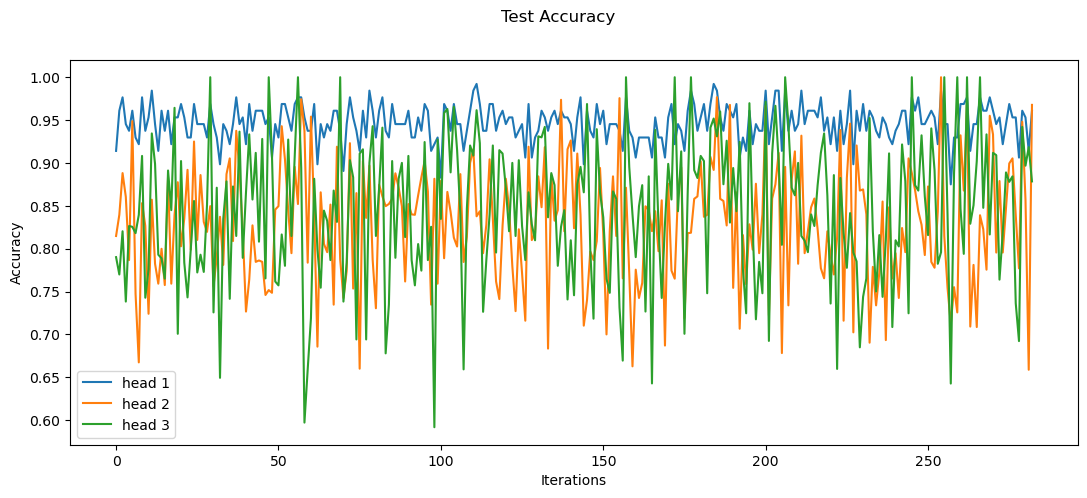

In [37]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Test Accuracy")
ax1.plot(np.array(test_accss[0]).flatten(),label="head 1")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

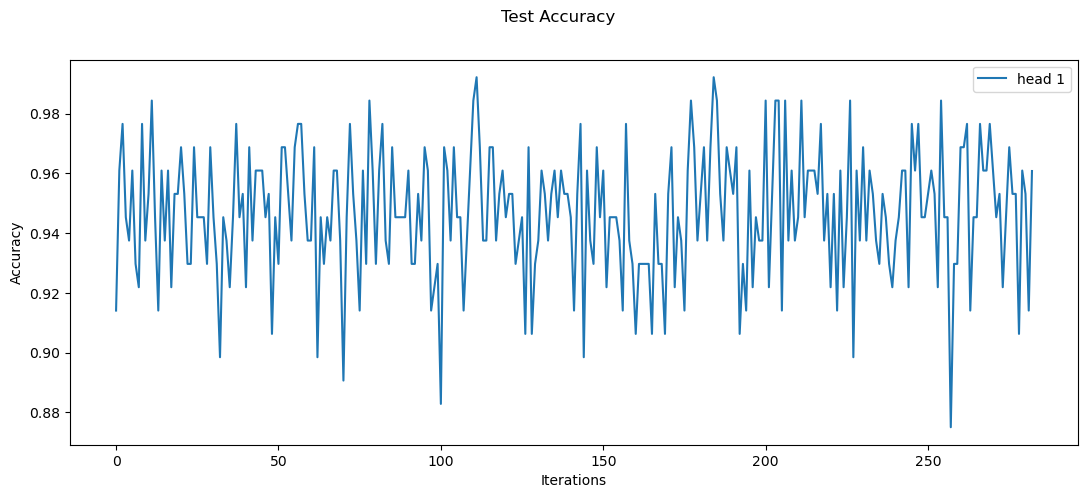

In [41]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Test Accuracy")
ax1.plot(np.array(test_accss[0]).flatten(),label="head 1")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

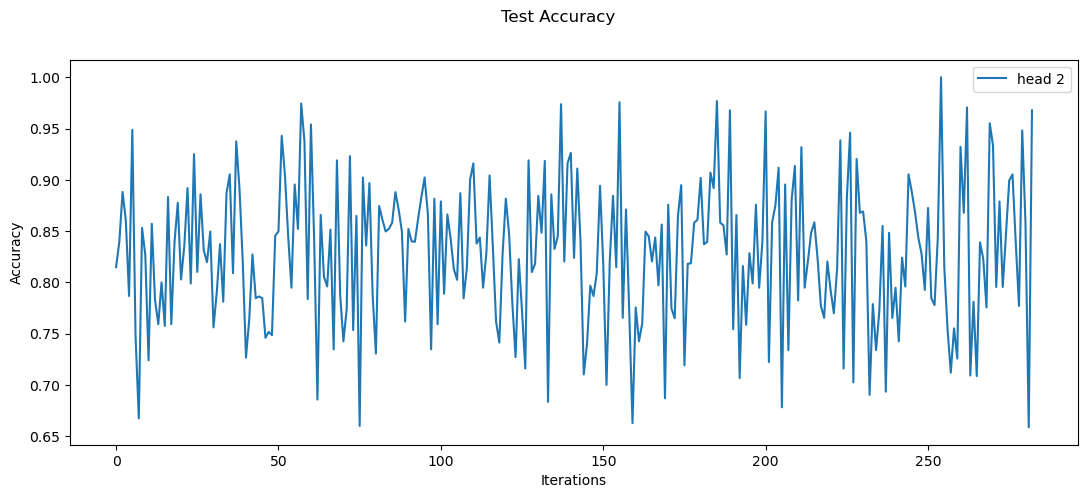

In [42]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Test Accuracy")
ax1.plot(np.array(test_accss[1]).flatten(),label="head 2")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

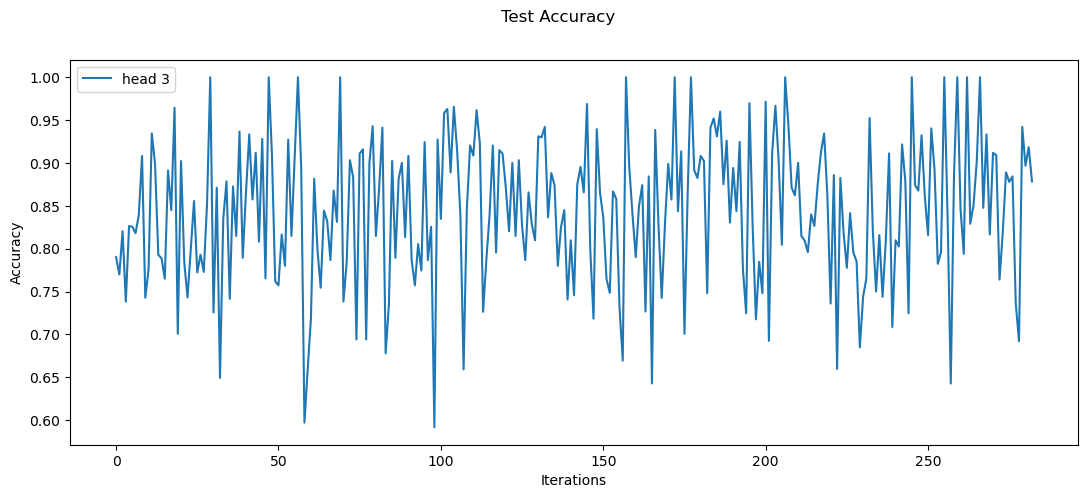

In [43]:
fig1, ax1 = plt.subplots(figsize=(13, 5))
fig1.suptitle("Test Accuracy")
ax1.plot(np.array(test_accss[2]).flatten(),label="head 3")
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
print(confusion1)
print(confusion2)
print(confusion3)

[[17568.  1189.]
 [  739. 16702.]]
[[1.773e+03 1.460e+02 3.060e+02 6.500e+01]
 [8.000e+00 3.139e+03 2.000e+00 3.000e+00]
 [1.910e+02 3.000e+00 1.877e+03 4.900e+01]
 [2.560e+02 3.500e+01 1.160e+02 2.425e+03]]
[[2.502e+03 2.600e+01 2.000e+00 0.000e+00]
 [1.400e+01 1.324e+03 4.000e+00 3.800e+01]
 [1.810e+02 0.000e+00 2.245e+03 1.200e+01]
 [3.320e+02 2.080e+02 9.300e+01 2.097e+03]]


In [3]:
with open('test_accs.pkl', 'rb') as f:
    test_accss = pickle.load(f)
with open('confusion1.pkl', 'rb') as f:
    confusion1 = pickle.load(f)
with open('confusion2.pkl', 'rb') as f:
    confusion2 = pickle.load(f)
with open('confusion3.pkl', 'rb') as f:
    confusion3 = pickle.load(f)

In [4]:
print(confusion1)
print(confusion2)
print(confusion3)

[[17568.  1189.]
 [  739. 16702.]]
[[1.773e+03 1.460e+02 3.060e+02 6.500e+01]
 [8.000e+00 3.139e+03 2.000e+00 3.000e+00]
 [1.910e+02 3.000e+00 1.877e+03 4.900e+01]
 [2.560e+02 3.500e+01 1.160e+02 2.425e+03]]
[[2.502e+03 2.600e+01 2.000e+00 0.000e+00]
 [1.400e+01 1.324e+03 4.000e+00 3.800e+01]
 [1.810e+02 0.000e+00 2.245e+03 1.200e+01]
 [3.320e+02 2.080e+02 9.300e+01 2.097e+03]]


In [140]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(8, 6)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    originalcm = cm.copy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fontsize=10
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:,}\n{:0.2f}%".format(int(originalcm[i, j]), 100*cm[i, j]), fontsize=fontsize,
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}%".format(int(cm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()   

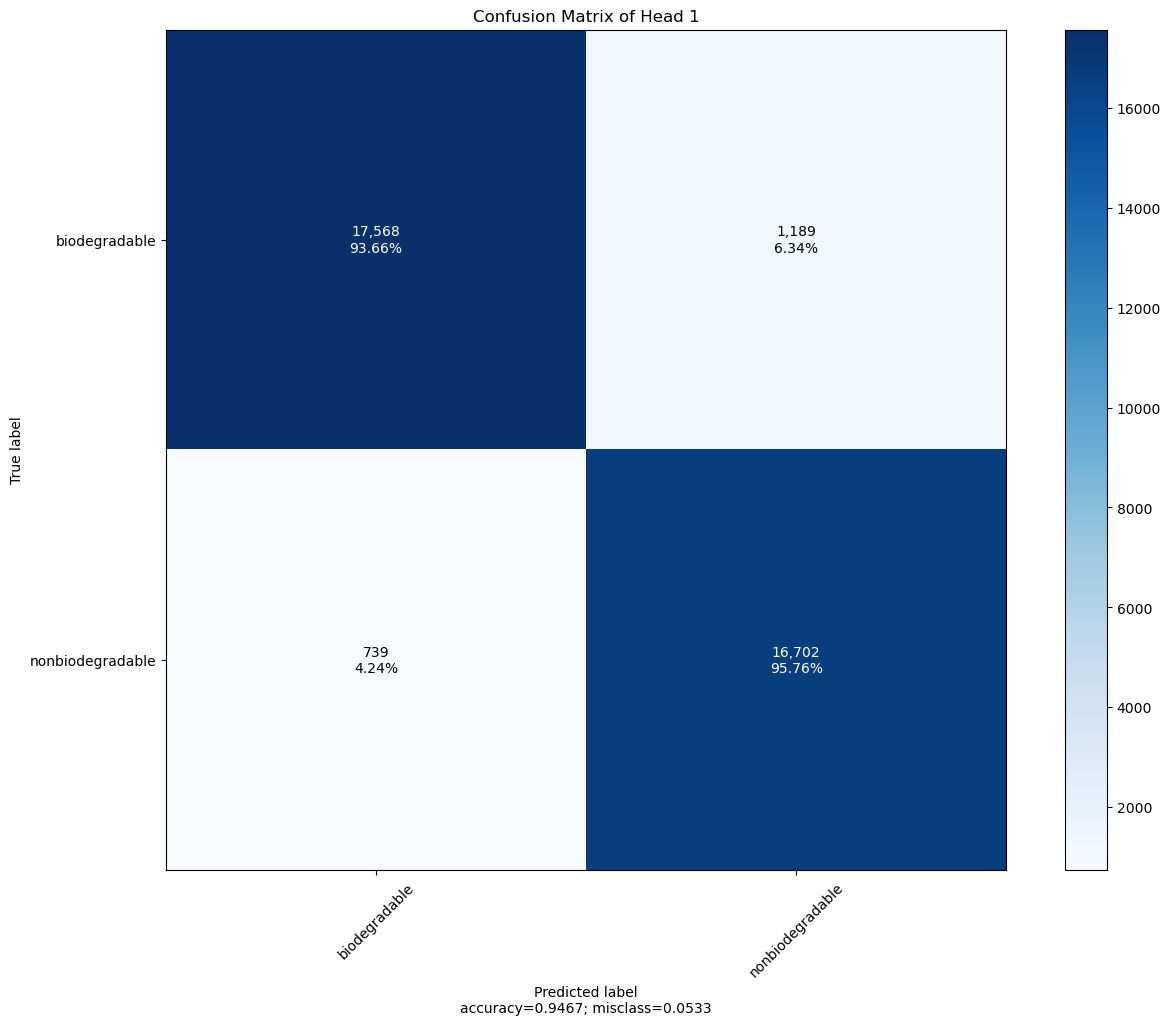

In [141]:
plot_confusion_matrix(confusion1, target_names=["biodegradable", "nonbiodegradable"] ,title="Confusion Matrix of Head 1", normalize=True, figsize=(13,10))

In [193]:
precisionsHead1 = {}
precisionsHead1["biodegradable"] = confusion1[0,0]/float(np.sum(confusion1[:,0]))
precisionsHead1["nonbiodegradable"] = confusion1[1,1]/float(np.sum(confusion1[:,1]))

recallsHead1 = {}
recallsHead1["biodegradable"] = confusion1[0,0]/float(np.sum(confusion1[0,:]))
recallsHead1["nonbiodegradable"] = confusion1[1,1]/float(np.sum(confusion1[1,:]))

f1sHead1 = {}
f1sHead1["biodegradable"] = 2*(precisionsHead1["biodegradable"]*recallsHead1["biodegradable"])/(precisionsHead1["biodegradable"]+recallsHead1["biodegradable"])
f1sHead1["nonbiodegradable"] = 2*(precisionsHead1["nonbiodegradable"]*recallsHead1["nonbiodegradable"])/(precisionsHead1["nonbiodegradable"]+recallsHead1["nonbiodegradable"])

accuracyHead1 = np.trace(confusion1) / float(np.sum(confusion1))

print(precisionsHead1)
print(recallsHead1)
print(f1sHead1)
print(accuracyHead1)

{'biodegradable': 0.95963292729557, 'nonbiodegradable': 0.9335420043597339}
{'biodegradable': 0.9366103321426668, 'nonbiodegradable': 0.9576285763430996}
{'biodegradable': 0.947981869199223, 'nonbiodegradable': 0.9454319030906826}
0.9467373888060114


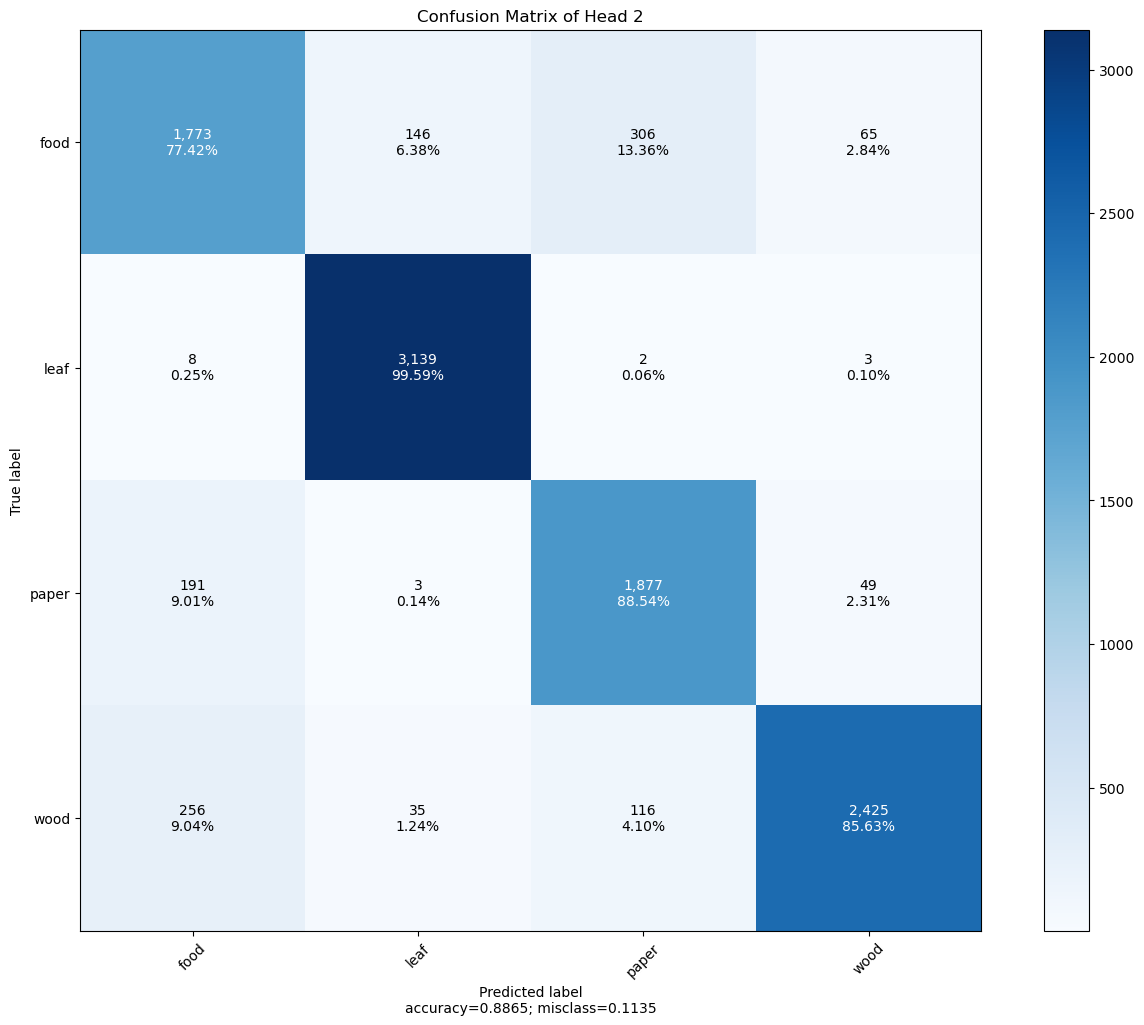

In [149]:
plot_confusion_matrix(confusion2, target_names=["food", "leaf", "paper", "wood"] ,title="Confusion Matrix of Head 2", normalize=True, figsize=(13,10))

In [192]:
precisionsHead2 = {}
precisionsHead2["food"] = confusion2[0,0]/float(np.sum(confusion2[:,0]))
precisionsHead2["leaf"] = confusion2[1,1]/float(np.sum(confusion2[:,1]))
precisionsHead2["paper"] = confusion2[2,2]/float(np.sum(confusion2[:,2]))
precisionsHead2["wood"] = confusion2[3,3]/float(np.sum(confusion2[:,3]))

recallsHead2 = {}
recallsHead2["food"] = confusion2[0,0]/float(np.sum(confusion2[0,:]))
recallsHead2["leaf"] = confusion2[1,1]/float(np.sum(confusion2[1,:]))
recallsHead2["paper"] = confusion2[2,2]/float(np.sum(confusion2[2,:]))
recallsHead2["wood"] = confusion2[3,3]/float(np.sum(confusion2[3,:]))

f1sHead2 = {}
f1sHead2["food"] = 2*(precisionsHead2["food"]*recallsHead2["food"])/(precisionsHead2["food"]+recallsHead2["food"])
f1sHead2["leaf"] = 2*(precisionsHead2["leaf"]*recallsHead2["leaf"])/(precisionsHead2["leaf"]+recallsHead2["leaf"])
f1sHead2["paper"] = 2*(precisionsHead2["paper"]*recallsHead2["paper"])/(precisionsHead2["paper"]+recallsHead2["paper"])
f1sHead2["wood"] = 2*(precisionsHead2["wood"]*recallsHead2["wood"])/(precisionsHead2["wood"]+recallsHead2["wood"])

accuracyHead2 = np.trace(confusion2) / float(np.sum(confusion2))

print(precisionsHead2)
print(recallsHead2)
print(f1sHead2)
print(accuracyHead2)

{'food': 0.7957809694793537, 'leaf': 0.9446283478784231, 'paper': 0.8157322903085615, 'wood': 0.9539732494099135}
{'food': 0.774235807860262, 'leaf': 0.9958756345177665, 'paper': 0.8853773584905661, 'wood': 0.8562853107344632}
{'food': 0.7848605577689244, 'leaf': 0.9695752895752895, 'paper': 0.8491291562994799, 'wood': 0.9024934871604019}
0.8864729651722147


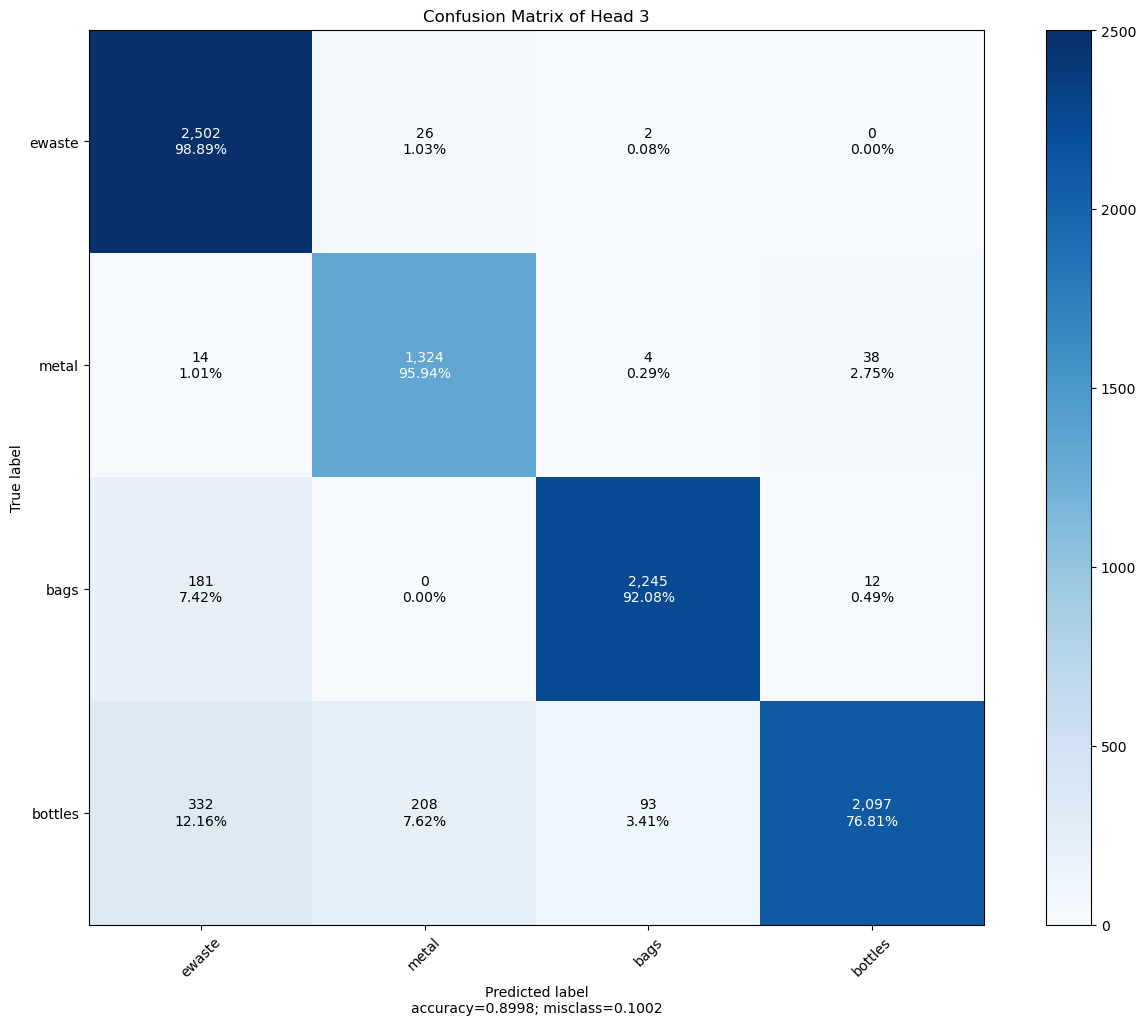

In [151]:
plot_confusion_matrix(confusion3, target_names=["ewaste", "metal", "bags", "bottles"] ,title="Confusion Matrix of Head 3", normalize=True, figsize=(13,10))

In [194]:
precisionsHead3 = {}
precisionsHead3["ewaste"] = confusion3[0,0]/float(np.sum(confusion3[:,0]))
precisionsHead3["metal"] = confusion3[1,1]/float(np.sum(confusion3[:,1]))
precisionsHead3["bags"] = confusion3[2,2]/float(np.sum(confusion3[:,2]))
precisionsHead3["bottles"] = confusion3[3,3]/float(np.sum(confusion3[:,3]))

recallsHead3 = {}
recallsHead3["ewaste"] = confusion3[0,0]/float(np.sum(confusion3[0,:]))
recallsHead3["metal"] = confusion3[1,1]/float(np.sum(confusion3[1,:]))
recallsHead3["bags"] = confusion3[2,2]/float(np.sum(confusion3[2,:]))
recallsHead3["bottles"] = confusion3[3,3]/float(np.sum(confusion3[3,:]))

f1sHead3 = {}
f1sHead3["ewaste"] = 2*(precisionsHead3["ewaste"]*recallsHead3["ewaste"])/(precisionsHead3["ewaste"]+recallsHead3["ewaste"])
f1sHead3["metal"] = 2*(precisionsHead3["metal"]*recallsHead3["metal"])/(precisionsHead3["metal"]+recallsHead3["metal"])
f1sHead3["bags"] = 2*(precisionsHead3["bags"]*recallsHead3["bags"])/(precisionsHead3["bags"]+recallsHead3["bags"])
f1sHead3["bottles"] = 2*(precisionsHead3["bottles"]*recallsHead3["bottles"])/(precisionsHead3["bottles"]+recallsHead3["bottles"])

accuracyHead3 = np.trace(confusion3) / float(np.sum(confusion3))

print(precisionsHead3)
print(recallsHead3)
print(f1sHead3)
print(accuracyHead3)

{'ewaste': 0.826015186530208, 'metal': 0.8498074454428755, 'bags': 0.9577645051194539, 'bottles': 0.9767116907312529}
{'ewaste': 0.9889328063241106, 'metal': 0.9594202898550724, 'bags': 0.920836751435603, 'bottles': 0.7681318681318682}
{'ewaste': 0.9001618996222343, 'metal': 0.9012933968686181, 'bags': 0.9389376829778334, 'bottles': 0.8599548903014148}
0.8997576558713373


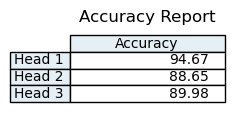

In [221]:
data = [[accuracyHead1], 
        [accuracyHead2], 
        [accuracyHead3]]
title_text = 'Accuracy Report'
row_headers = ["Head 1","Head 2","Head 3"]
column_headers = ["Accuracy"]
cell_text = []
for row in data:
    cell_text.append([f'{100*x:.2f}' for x in row])
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
fig, ax1 = plt.subplots(figsize=(2, 1))
the_table = ax1.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      loc='center')
the_table.scale(1, 1)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
ax.set_title(title_text)
plt.draw()


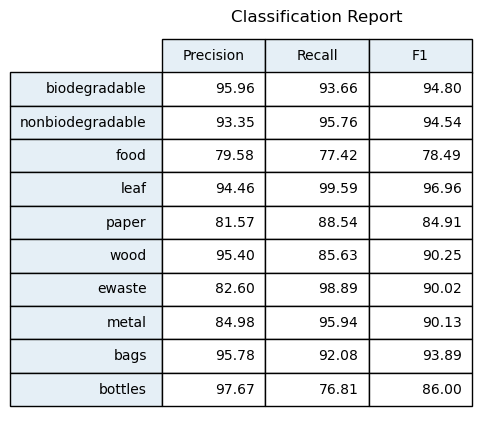

In [223]:
data = [[precisionsHead1["biodegradable"], recallsHead1["biodegradable"], f1sHead1["biodegradable"]],
        [precisionsHead1["nonbiodegradable"], recallsHead1["nonbiodegradable"], f1sHead1["nonbiodegradable"]],
        [precisionsHead2["food"], recallsHead2["food"], f1sHead2["food"]],
        [precisionsHead2["leaf"], recallsHead2["leaf"], f1sHead2["leaf"]],
        [precisionsHead2["paper"], recallsHead2["paper"], f1sHead2["paper"]],
        [precisionsHead2["wood"], recallsHead2["wood"], f1sHead2["wood"]],
        [precisionsHead3["ewaste"], recallsHead3["ewaste"], f1sHead3["ewaste"]],
        [precisionsHead3["metal"], recallsHead3["metal"], f1sHead3["metal"]],
        [precisionsHead3["bags"], recallsHead3["bags"], f1sHead3["bags"]],
        [precisionsHead3["bottles"], recallsHead3["bottles"], f1sHead3["bottles"]]]
title_text = 'Classification Report'
row_headers = ["biodegradable","nonbiodegradable","food","leaf","paper","wood","ewaste","metal","bags","bottles"]
column_headers = ["Precision", "Recall", "F1"]
cell_text = []
for row in data:
    cell_text.append([f'{100*x:.2f}' for x in row])
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
fig, ax1 = plt.subplots(figsize=(4, 5))
the_table = ax1.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      loc='center')
the_table.scale(1, 2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
ax.set_title(title_text)
plt.draw()